## Customer Complaint Classification Project

#### Purpose:

+ A seamless and great customer experience is one of the most important pillars in a successful business today
+ Companies spend lots of resources for consumer complaint handling and to ensure that the customers affected do not go to a competitor
+ That being said, there are ways in which Machine Learning can be applied, saving money and resources

In [103]:
# importing libraries for project

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import string

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')

# reading in the csv and storing it under df
df = pd.read_csv('data/consumer_complaints.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chaco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [104]:
# print the total amount of rows and columns in this dataset
print(df.shape)

# taking a look a first five rows of the dataset
df.head(5)

(9999, 18)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer Complaint,Company Public Response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date Sent to Company,Company Response to Consumer,Timely response?,Consumer disputed?,Complaint ID
0,3/12/14,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,M&T BANK CORPORATION,MI,48382,NaN,NaN,Referral,3/17/14,Closed with explanation,Yes,No,759217
1,10/1/16,Credit reporting,NaN,Incorrect information on credit report,Account status,I have outdated information on my credit repor...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",AL,352XX,NaN,Consent provided,Web,10/5/16,Closed with explanation,Yes,No,2141773
2,10/17/16,Consumer Loan,Vehicle loan,Managing the loan or lease,NaN,I purchased a new car on XXXX XXXX. The car de...,NaN,"CITIZENS FINANCIAL GROUP, INC.",PA,177XX,Older American,Consent provided,Web,10/20/16,Closed with explanation,Yes,No,2163100
3,6/8/14,Credit card,NaN,Bankruptcy,NaN,NaN,NaN,AMERICAN EXPRESS COMPANY,ID,83854,Older American,NaN,Web,6/10/14,Closed with explanation,Yes,Yes,885638
4,9/13/14,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,NaN,NaN,"CITIBANK, N.A.",VA,23233,NaN,NaN,Web,9/13/14,Closed with explanation,Yes,Yes,1027760


In [105]:
# creating a new table called consumer_complaints as these are the two variables used in this project
consumer_complaints = df[['Consumer Complaint', 'Product']]

# taking a look at the first five rows of the dcoc
consumer_complaints.head(5)

,Consumer Complaint,Product
0,NaN,Mortgage
1,I have outdated information on my credit repor...,Credit reporting
2,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan
3,NaN,Credit card
4,NaN,Debt collection


In [106]:
# looking any null values in the dataset

consumer_complaints.isnull().sum()

Consumer Complaint    7885
Product                  0
dtype: int64

In [118]:
# 

null = len(consumer_complaints[consumer_complaints['Consumer Complaint'].isnull()]['Consumer Complaint'])
total = len(df)

print(f'The percentage of null values is {round(null/total * 100,0)}%. What does this mean? 1 out of every 5 reviews will contain content from the customer as to why they are complaining')

The percentage of null values is 0.0%. What does this mean? 1 out of every 5 reviews will contain content from the customer as to why they are complaining


#### What to do with these null values?

+ Since this project is solely focused on the complaint by the customer, null values are of no use
+ With that being said, 79% of complaints are null
+ Or essentially, 1 in 5 complaints will contain customer content as to why they did not enjoy the product

In [108]:
# dropping all null values

consumer_complaints = consumer_complaints.dropna()

In [109]:
# ensuring there are no null values in the dataset

consumer_complaints.isnull().sum()

Consumer Complaint    0
Product               0
dtype: int64

In [110]:
# creating a new table grouped by the product an counting the amount of complaints per product
product_complaints = consumer_complaints.groupby('Product').count()['Consumer Complaint'].reset_index().sort_values(by = 'Consumer Complaint', ascending = False)


# storing both variables in different lists, for data visualization purposes
x = product_complaints['Consumer Complaint']
y = product_complaints['Product']

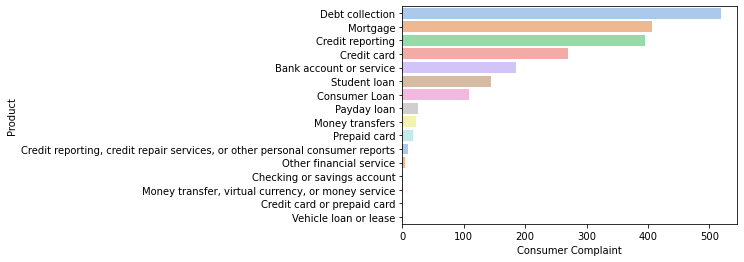

In [111]:
# Using seaborn to create a bargraph 

sns.barplot(x = x, y = y, palette = sns.color_palette('pastel') )
plt.show();

In [112]:
# creating a function to clean the data

def preprocess(text):
    text = text.lower() # lowering all text
    text = text.strip()  # removing whitespace
    text = re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub(r'\W', ' ', str(text)) # removing special characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text) # remove single characters 
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text ) # remove single characters from the beginning
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'(#[\d\w\.]+)', '', text) # removing hashtags
    text = re.sub(r'(@[\d\w\.]+)', '', text) # removing @ handles 
    text = re.sub(r'\[[0-9]*\]',' ',text) # removing numbers
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

In [113]:
# creating a new column with the clean text

consumer_complaints['complaint_clean'] = consumer_complaints['Consumer Complaint'].apply(lambda x: preprocess(x))

In [114]:
# taking a look at the data to ensure the preprocess function worked accordingly

consumer_complaints.head(5)

,Consumer Complaint,Product,complaint_clean
1,I have outdated information on my credit repor...,Credit reporting,i have outdated information on my credit repor...
2,I purchased a new car on XXXX XXXX. The car de...,Consumer Loan,i purchased new car on xxxx xxxx the car deale...
7,An account on my credit report has a mistaken ...,Credit reporting,an account on my credit report has mistaken da...
12,This company refuses to provide me verificatio...,Debt collection,this company refuses to provide me verificatio...
16,This complaint is in regards to Square Two Fin...,Debt collection,this complaint is in regards to square two fin...
...,...,...,...
9987,on XX/XX/2016 I checked my credit report and a...,Credit reporting,on xx xx checked my credit report and all my i...
9988,This complaint is in regards to unauthorized f...,Mortgage,this complaint is in regards to unauthorized f...
9990,"In XXXX 2015, I received a notice from a compa...",Debt collection,in xxxx received notice from company named xxx...
9994,Freedom Mortgage has paid my XX/XX/2014 XXXX X...,Mortgage,freedom mortgage has paid my xx xx xxxx xxxx p...


In [115]:
# storing the english stop words under stop_words
# this will be added to the model syntax

stop_words = set(stopwords.words('english'))

X = consumer_complaints['complaint_clean']
y = consumer_complaints['Product']

tfidf = TfidfVectorizer(max_features = 3000, min_df = 10, max_df = 0.7, stop_words = stop_words)

X = tfidf.fit_transform(X)

In [116]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 500, random_state = 42)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.76      0.65      0.70        34
                                                               Consumer Loan       0.75      0.12      0.21        25
                                                                 Credit card       0.71      0.80      0.76        46
                                                            Credit reporting       0.74      0.82      0.78        77
Credit reporting, credit repair services, or other personal consumer reports       0.00      0.00      0.00         3
                                                             Debt collection       0.70      0.86      0.77       101
                          Money transfer, virtual currency, or money service       0.00      0.00      0.00         1
                                                       

C:\Users\chaco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chaco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\chaco\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
